In this project we will work with housing data for the city of Ames, Iowa, United States from 2006 to 2010. We can read more about why the data was collected [here](http://ww2.amstat.org/publications/jse/v19n3/decock.pdf). We can also read about the different columns in the data [here](https://ww2.amstat.org/publications/jse/v19n3/decock/DataDocumentation.txt).

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.model_selection import KFold

df = pd.read_csv('AmesHousing.txt', delimiter='\t')
df.shape

(2930, 82)

# Feature Engineering

In [83]:
# null columns with number of null values
data_nulls = data.isnull().sum()
data_nulls

Order                0
PID                  0
MS SubClass          0
MS Zoning            0
Lot Frontage       490
Lot Area             0
Street               0
Alley             2732
Lot Shape            0
Land Contour         0
Utilities            0
Lot Config           0
Land Slope           0
Neighborhood         0
Condition 1          0
Condition 2          0
Bldg Type            0
House Style          0
Overall Qual         0
Overall Cond         0
Year Built           0
Year Remod/Add       0
Roof Style           0
Roof Matl            0
Exterior 1st         0
Exterior 2nd         0
Mas Vnr Type        23
Mas Vnr Area        23
Exter Qual           0
Exter Cond           0
                  ... 
Bedroom AbvGr        0
Kitchen AbvGr        0
Kitchen Qual         0
TotRms AbvGrd        0
Functional           0
Fireplaces           0
Fireplace Qu      1422
Garage Type        157
Garage Yr Blt      159
Garage Finish      159
Garage Cars          1
Garage Area          1
Garage Qual

# Drop columns

In [ ]:
# Drop columns having < 5% missing values

In [84]:
# Filter Series to columns containing >5% missing values
drop_missing_cols = data_nulls[(data_nulls > len(df)/20)].sort_values()

# Drop those columns from the data frame. Note the use of the .index accessor
df = df.drop(drop_missing_cols.index, axis=1)
df.isnull().sum()

Order               0
PID                 0
MS SubClass         0
MS Zoning           0
Lot Area            0
Street              0
Lot Shape           0
Land Contour        0
Utilities           0
Lot Config          0
Land Slope          0
Neighborhood        0
Condition 1         0
Condition 2         0
Bldg Type           0
House Style         0
Overall Qual        0
Overall Cond        0
Year Built          0
Year Remod/Add      0
Roof Style          0
Roof Matl           0
Exterior 1st        0
Exterior 2nd        0
Mas Vnr Type       23
Mas Vnr Area       23
Exter Qual          0
Exter Cond          0
Foundation          0
Bsmt Qual          80
                   ..
Electrical          1
1st Flr SF          0
2nd Flr SF          0
Low Qual Fin SF     0
Gr Liv Area         0
Bsmt Full Bath      2
Bsmt Half Bath      2
Full Bath           0
Half Bath           0
Bedroom AbvGr       0
Kitchen AbvGr       0
Kitchen Qual        0
TotRms AbvGrd       0
Functional          0
Fireplaces

In [ ]:
# Drop "object" columns having missing values

In [86]:
## Series object: column name -> number of missing values
object_nulls = df.select_dtypes(include=['object']).isnull().sum().sort_values(ascending=False)

## Filter Series to columns containing missing values
df = df.drop(object_nulls[object_nulls > 0].index, axis=1)

In [ ]:
# Fill numerical columns with most common value in that column

In [88]:
num_missing = df.select_dtypes(include=['integer', 'float']).isnull().sum()
fill_numeric_cols = num_missing[(num_missing < len(df)/20) & (num_missing > 0)].sort_values()
fill_numeric_cols

BsmtFin SF 1       1
BsmtFin SF 2       1
Bsmt Unf SF        1
Total Bsmt SF      1
Garage Cars        1
Garage Area        1
Bsmt Full Bath     2
Bsmt Half Bath     2
Mas Vnr Area      23
dtype: int64

In [90]:
# find column's mode.
mode_vals_dict = df[fill_numeric_cols.index].mode().to_dict(orient='records')[0]
mode_vals_dict

{'BsmtFin SF 1': 0.0,
 'BsmtFin SF 2': 0.0,
 'Bsmt Unf SF': 0.0,
 'Total Bsmt SF': 0.0,
 'Garage Cars': 2.0,
 'Garage Area': 0.0,
 'Bsmt Full Bath': 0.0,
 'Bsmt Half Bath': 0.0,
 'Mas Vnr Area': 0.0}

In [91]:
# fill columns with respective mode values
df = df.fillna(mode_vals_dict)

In [92]:
# confirm if df has any nulls
df.isnull().sum().value_counts()

0    64
dtype: int64

# Add new features

In [93]:
# Add a new column years since remodel
years_sold = df['Yr Sold'] - df['Year Built']
years_sold[years_sold < 0]

2180   -1
dtype: int64

In [95]:
years_since_remod = df['Yr Sold'] - df['Year Remod/Add']
years_since_remod[years_since_remod < 0]

1702   -1
2180   -2
2181   -1
dtype: int64

In [96]:
## Create new columns
df['Years Before Sale'] = years_sold
df['Years Since Remod'] = years_since_remod

## Drop rows with negative values for both of these new features
df = df.drop((years_since_remod < 0).index, axis=0)

## No longer need original year columns
df= d.drop(["Year Built", "Year Remod/Add"], axis = 1)

In [97]:
# Drop columns that:
# aren't useful for predicting the price
df = df.drop(["PID", "Order"], axis=1)

# leak info about the final sale
df = df.drop(["Mo Sold", "Sale Condition", "Sale Type", "Yr Sold"], axis=1)

# Create Functions

In [98]:
# Summarize the data cleaning tasks into a new function transform_features()
def transform_features(df):
    num_missing = df.isnull().sum()
    drop_missing_cols = num_missing[(num_missing > len(df)/20)].sort_values()
    df = df.drop(drop_missing_cols.index, axis=1)
    
    text_mv_counts = df.select_dtypes(include=['object']).isnull().sum().sort_values(ascending=False)
    drop_missing_cols_2 = text_mv_counts[text_mv_counts > 0]
    df = df.drop(drop_missing_cols_2.index, axis=1)
    
    num_missing = df.select_dtypes(include=['int', 'float']).isnull().sum()
    fixable_numeric_cols = num_missing[(num_missing < len(df)/20) & (num_missing > 0)].sort_values()
    replacement_values_dict = df[fixable_numeric_cols.index].mode().to_dict(orient='records')[0]
    df = df.fillna(replacement_values_dict)
    
    years_sold = df['Yr Sold'] - df['Year Built']
    years_since_remod = df['Yr Sold'] - df['Year Remod/Add']
    df['Years Before Sale'] = years_sold
    df['Years Since Remod'] = years_since_remod
    df = df.drop([1702, 2180, 2181], axis=0)

    df = df.drop(["PID", "Order", "Mo Sold", "Sale Condition", "Sale Type", "Year Built", "Year Remod/Add"], axis=1)
    return df

def select_features(df):
    # input feature, target label
    return df[["Gr Liv Area", "SalePrice"]]

def train_and_test(df):  
    train = df[:1460]
    test = df[1460:]
    
    numeric_train = train.select_dtypes(include=['integer', 'float'])
    numeric_test = test.select_dtypes(include=['integer', 'float'])
    features = numeric_train.columns.drop("SalePrice")
    
    #univariate linear regression
    lr = linear_model.LinearRegression()
    
    #fit the model
    lr.fit(train[features], train["SalePrice"])
    
    #make predictions
    predictions = lr.predict(test[features])
    
    #calculate mean square error
    mse = mean_squared_error(test["SalePrice"], predictions)
    # calculate root mean square error
    rmse = np.sqrt(mse)
    
    return rmse

In [100]:
# calculate rmse
df = pd.read_csv("AmesHousing.txt", delimiter="\t")
transform_df = transform_features(df)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df)

rmse

55275.367312413066

# Feature Selection

Generate a correlation heatmap matrix of the numerical features in the training data set.
* Which features correlate strongly with our target column, SalePrice?
* Calculate the correlation coefficients for the columns that seem to correlate well with SalePrice. 
Because we have a pipeline in place, it's easy to try different features and see which features result in a better cross validation score.

In [102]:
numerical_df = transform_df.select_dtypes(include=['integer', 'float'])
abs_corr_coeffs = numerical_df.corr()['SalePrice'].abs().sort_values()
abs_corr_coeffs

BsmtFin SF 2         0.006127
Misc Val             0.019273
Yr Sold              0.030358
3Ssn Porch           0.032268
Bsmt Half Bath       0.035875
Low Qual Fin SF      0.037629
Pool Area            0.068438
MS SubClass          0.085128
Overall Cond         0.101540
Screen Porch         0.112280
Kitchen AbvGr        0.119760
Enclosed Porch       0.128685
Bedroom AbvGr        0.143916
Bsmt Unf SF          0.182751
Lot Area             0.267520
2nd Flr SF           0.269601
Bsmt Full Bath       0.276258
Half Bath            0.284871
Open Porch SF        0.316262
Wood Deck SF         0.328183
BsmtFin SF 1         0.439284
Fireplaces           0.474831
TotRms AbvGrd        0.498574
Mas Vnr Area         0.506983
Years Since Remod    0.534985
Full Bath            0.546118
Years Before Sale    0.558979
1st Flr SF           0.635185
Garage Area          0.641425
Total Bsmt SF        0.644012
Garage Cars          0.648361
Gr Liv Area          0.717596
Overall Qual         0.801206
SalePrice 

In [103]:
# Drop columns with less than 0.4 correlation with SalePrice
transform_df = transform_df.drop(abs_corr_coeffs[abs_corr_coeffs < 0.4].index, axis=1)

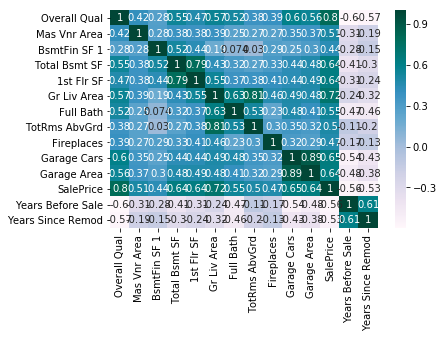

In [104]:
import seaborn as sns
%matplotlib inline 

sns.heatmap(transform_df.corr(), annot=True, cmap="PuBuGn")

# Address Catgorical data

Which columns in the data frame should be converted to the categorical data type? All of the columns marked as nominal from the documentation are candidates for being converted to categorical.

In [106]:
# Create a list of column names from documentation that are *meant* to be categorical
nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]

* Which columns are currently numerical but need to be encoded as categorical instead (because the numbers don't have any semantic meaning)?
* If a categorical column has hundreds of unique values (or categories), should we keep it? When we dummy code this column, hundreds of columns will need to be added back to the data frame.

In [107]:
# Test which categorical columns we still have 
transform_cat_cols = []
for col in nominal_features:
    if col in transform_df.columns:
        transform_cat_cols.append(col)

# How many unique values in each categorical column?
uniqueness_counts = transform_df[transform_cat_cols].apply(lambda col: len(col.value_counts())).sort_values()
print(uniqueness_counts)

# Aribtrary cutoff of 10 unique values (worth experimenting)
drop_nonuniq_cols = uniqueness_counts[uniqueness_counts > 10].index
transform_df = transform_df.drop(drop_nonuniq_cols, axis=1)

Street           2
Central Air      2
Land Contour     4
Lot Config       5
Bldg Type        5
Roof Style       6
Foundation       6
Heating          6
MS Zoning        7
Condition 2      8
House Style      8
Roof Matl        8
Condition 1      9
Exterior 1st    16
Exterior 2nd    17
Neighborhood    28
dtype: int64


In [108]:
# Select the remaining text columns and convert to categorical
text_cols = transform_df.select_dtypes(include=['object'])
for col in text_cols:
    transform_df[col] = transform_df[col].astype('category')
    
# Create dummy columns and add back to the dataframe
transform_df = pd.concat([transform_df, pd.get_dummies(transform_df.select_dtypes(include=['category']))], axis=1)

In [111]:
# summarize feature selection tasks to the function select_features()
def select_features(df, coeff_threshold=0.4, uniq_threshold=10):
    numerical_df = df.select_dtypes(include=['integer', 'float'])
    abs_corr_coeffs = numerical_df.corr()['SalePrice'].abs().sort_values()
    df = df.drop(abs_corr_coeffs[abs_corr_coeffs < coeff_threshold].index, axis=1)
    
    nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]
    
    transform_cat_cols = []
    for col in nominal_features:
        if col in df.columns:
            transform_cat_cols.append(col)

    uniqueness_counts = df[transform_cat_cols].apply(lambda col: len(col.value_counts())).sort_values()
    drop_nonuniq_cols = uniqueness_counts[uniqueness_counts > 10].index
    df = df.drop(drop_nonuniq_cols, axis=1)
    
    text_cols = df.select_dtypes(include=['object'])
    for col in text_cols:
        df[col] = df[col].astype('category')
    df = pd.concat([df, pd.get_dummies(df.select_dtypes(include=['category']))], axis=1)
    
    return df

# Cross Validation

Update the train_and_test() function to perform cross validation
* The optional k parameter should accept integer values, with a default value of 0.
* When k equals 0, perform holdout validation (what we already implemented):
  * Select the first 1460 rows and assign to train.
  * Select the remaining rows and assign to test.
  * Train on train and test on test.
  * Compute the RMSE and return.
* When k equals 1, perform simple cross validation:
  * Shuffle the ordering of the rows in the data frame.
  * Select the first 1460 rows and assign to fold_one.
  * Select the remaining rows and assign to fold_two.
  * Train on fold_one and test on fold_two.
  * Train on fold_two and test on fold_one.
  * Compute the average RMSE and return.
* When k is greater than 0, implement k-fold cross validation using k folds:
  * Perform k-fold cross validation using k folds.
  * Calculate the average RMSE value and return this value.

In [116]:
def train_and_test(df, k=0):
    numeric_df = df.select_dtypes(include=['integer', 'float'])
    features = numeric_df.columns.drop("SalePrice")
    lr = linear_model.LinearRegression()
    
    if k == 0:
        train = df[:1460]
        test = df[1460:]

        lr.fit(train[features], train["SalePrice"])
        predictions = lr.predict(test[features])
        mse = mean_squared_error(test["SalePrice"], predictions)
        rmse = np.sqrt(mse)

        return rmse
    
    if k == 1:
        # Randomize *all* rows (frac=1) from `df` and return
        shuffled_df = df.sample(frac=1, )
        train = df[:1460]
        test = df[1460:]
        
        lr.fit(train[features], train["SalePrice"])
        predictions_one = lr.predict(test[features])        
        
        mse_one = mean_squared_error(test["SalePrice"], predictions_one)
        rmse_one = np.sqrt(mse_one)
        
        lr.fit(test[features], test["SalePrice"])
        predictions_two = lr.predict(train[features])        
       
        mse_two = mean_squared_error(train["SalePrice"], predictions_two)
        rmse_two = np.sqrt(mse_two)
        
        avg_rmse = np.mean([rmse_one, rmse_two])
        print(rmse_one)
        print(rmse_two)
        return avg_rmse
    else:
        kf = KFold(n_splits=k, shuffle=True)
        rmse_values = []
        for train_index, test_index, in kf.split(df):
            train = df.iloc[train_index]
            test = df.iloc[test_index]
            lr.fit(train[features], train["SalePrice"])
            predictions = lr.predict(test[features])
            mse = mean_squared_error(test["SalePrice"], predictions)
            rmse = np.sqrt(mse)
            rmse_values.append(rmse)
        print(rmse_values)
        avg_rmse = np.mean(rmse_values)
        return avg_rmse

In [117]:
df = pd.read_csv("AmesHousing.txt", delimiter="\t")
transform_df = transform_features(df)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df, k=4)

rmse

[25753.848555843608, 27260.647539572143, 26476.12216092028, 36675.655872189323]


29041.568532131339

The rmse using univariate LR has been improved by feature selection and k-fold cross validation by 52%